<a href="https://colab.research.google.com/github/wojtek2kdev/Obliczenia_naukowe/blob/main/27.04.2022/lekcja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

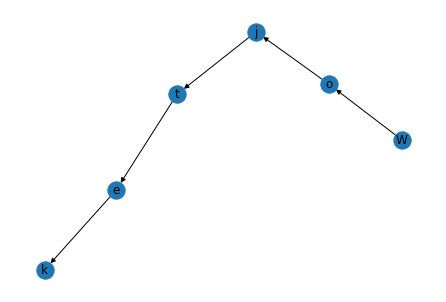

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

name = "Wojtek"
G = nx.DiGraph(zip(name[:-1], name[1:]))
nx.draw(G, with_labels=True)


* Pomaranczowe linie to krawędzie z przesiadkami.
* Na różowo najszybsza trasa z C5 do Y3, na fioletowo część najkrótszej trasy w sensie stacji.
 

Przejechanie najszybszą trasą z C5 do Y3 zamjuje 30.


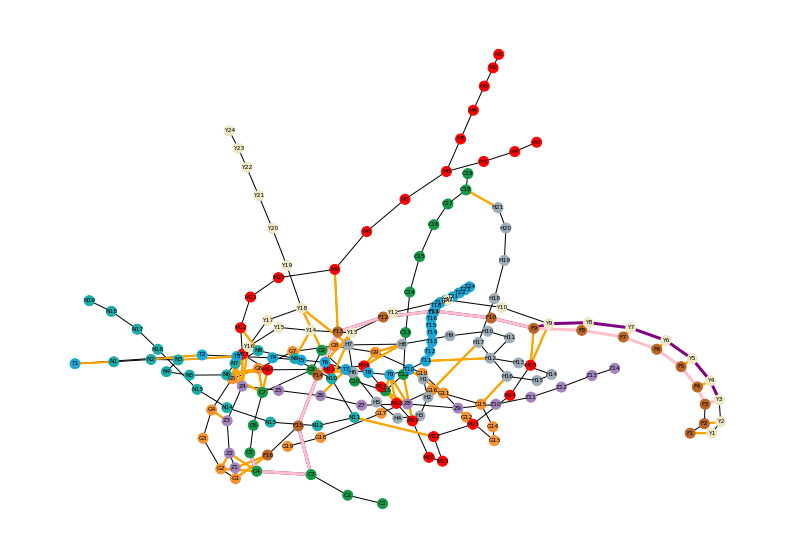

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import requests as req

from more_itertools import flatten, pairwise, chunked
from toolz.itertoolz import first, second
from toolz.functoolz import pipe, flip, apply, curry, compose
from toolz.curried import map, get, filter
from itertools import starmap

from operator import methodcaller, contains
from random import sample

cf = compose(curry, flip)

data = req.get("https://raw.githubusercontent.com/danio2010/ON2022/main/tokyo-metro.json").json()

transfers = pipe(data.values(),
                 map(get("transfers")),
                 flatten,
                 list)

travel_times = pipe(data.values(),
                    map(get("travel_times")),
                    flatten,
                    list)

metro = nx.Graph()
metro.add_weighted_edges_from(travel_times, transfer=False)
metro.add_edges_from(transfers, transfer=True)

colors = pipe(metro.nodes(),
              map(first),
              map(methodcaller("upper")),
              map(flip(get)(data)),
              map(get("color")),
              list    
         )

fig, ax = plt.subplots(1,1,figsize=(14,10))
pos_m = nx.spring_layout(metro, seed=143)

nx.draw(metro, pos=pos_m, ax=ax, node_size=100, node_color=colors)
nx.draw_networkx_labels(metro, pos=pos_m, ax=ax, font_size=6)
nx.draw_networkx_edges(metro, pos=pos_m, ax=ax, edgelist=transfers, width=2, edge_color="orange")

start_stations = list(nx.subgraph_view(metro, filter_node = lambda n: metro.degree(n) == 1))
shortest_path = pipe(nx.shortest_path(metro, "C5", "Y3"),
                     pairwise,
                     list)
fastest_path = pipe(nx.shortest_path(metro, "C5", "Y3", "weight"),
                    pairwise,
                    list)

nx.draw_networkx_edges(metro, pos=pos_m, ax=ax, edgelist=shortest_path, edge_color="purple", width=3)
nx.draw_networkx_edges(metro, pos=pos_m, ax=ax, edgelist=fastest_path, edge_color="pink", width=3)

def time_of_travel(stations):
  return pipe(stations,
              pairwise,
              curry(starmap)(metro.get_edge_data),
              filter(cf(contains)("weight")),
              map(get("weight")),
              sum
         )

t = time_of_travel(nx.shortest_path(metro, "C5", "Y3", "weight"))
print(f"Przejechanie najszybszą trasą z C5 do Y3 zamjuje {t}.")

In [2]:
transfer_weight = lambda edge: (edge, {"weight": metro.degree(edge[0])*metro.degree(edge[1])/4})

transfer_edges_weights = pipe(transfers,
                              map(tuple),
                              map(transfer_weight),
                              dict
                         )

nx.set_edge_attributes(metro, transfer_edges_weights)

connections = pipe(metro.nodes(),
                   cf(sample)(10),
                   cf(chunked)(2),
                   map(tuple),
                   map(lambda edge: (edge, nx.shortest_path(metro, edge[0], edge[1], "weight"))),
                   map(lambda path: (*path[0], time_of_travel(path[1]))),
                   list)


import pandas as pd

pd.DataFrame(connections, columns=["source", "target", "time"])

,source,target,time
0,H12,m5,33.00
1,T11,T24,451.00
2,G12,G11,2.00
3,Z11,Y1,51.25
4,H8,m3,30.00


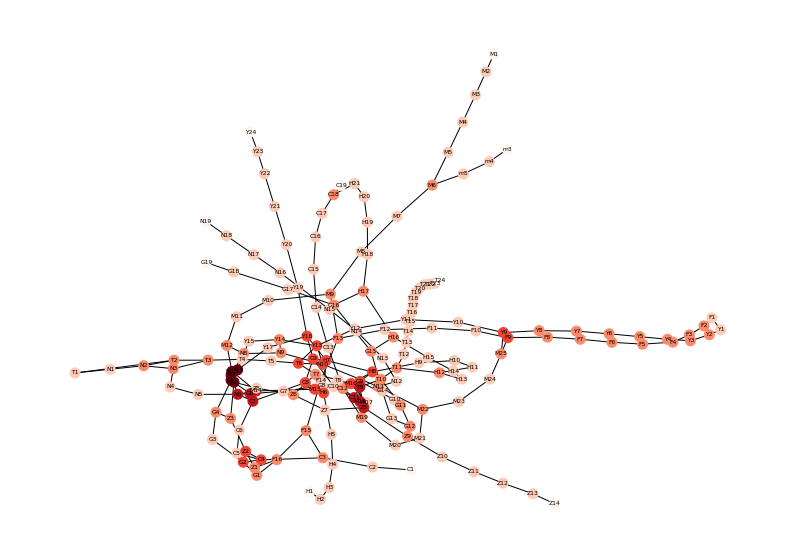

In [10]:
fig, ax = plt.subplots(1,1,figsize=(14,10))
pos_m = nx.spring_layout(metro, seed=143)

nx.draw_networkx_labels(metro, pos=pos_m, ax=ax, font_size=6)
nx.draw(metro, 
        pos=pos_m, 
        ax=ax, 
        node_size=100, 
        node_color=list(nx.degree_centrality(metro).values()), 
        cmap=plt.cm.Reds)

In [45]:

G = nx.DiGraph([
    (1,2),
    (2,3),
    (3,4),
    (4,1),
    (4,5),
    (5,1)  
])

pg = nx.pagerank(G)

M = nx.to_numpy_array(G).T
M /= M.sum(axis=0)

weights = np.array([1/5,1/5,1/5,1/5,1/5])

np.linalg.matrix_power(M, 20) @ weights



array([0.225  , 0.2375 , 0.225  , 0.20625, 0.10625])